In [ ]:
!unzip archive.zip

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/driver-inattention-detection-dataset/README.dataset.txt
/kaggle/input/driver-inattention-detection-dataset/README.roboflow.txt
/kaggle/input/driver-inattention-detection-dataset/valid/gA_1_s2_ir_face_mp4-176_jpg.rf.693fa1c65846758c1cddc0f8415a8766.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gA_2_s2_ir_face_mp4-227_jpg.rf.a3ae53497a4af8b61f5bba0372554b19.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-549_jpg.rf.65e47acbce7c18d72317af02550fba9a.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_7_s2_2019-03-11T14-12-25-01-00_ir_face_mp4-354_jpg.rf.2cec3b6e6fd05f56e3561593258d7ea0.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_10_s2_2019-03-11T15-15-21-01-00_ir_face_mp4-844_jpg.rf.f6c242cbc1bcef3e8732297d30a0a10f.jpg
/kaggle/input/driver-inattention-detection-dataset/valid/gB_6_s2_2019-03-11T13-46-14-01-00_ir_face_mp4-613_jpg.rf.55300d462163c8291b6ca7d1604422fc.jpg
/kag

# **Import all the required dependancies**

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# **Visualization of the dataset with the labels**

In [ ]:
train_images_path = '/kaggle/input/driver-inattention-detection-dataset/train'
annotation_file_path = '/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt'

class_names = {
    0: 'DangerousDriving',
    1: 'Distracted',
    2: 'Drinking',
    3: 'SafeDriving',
    4: 'SleepyDriving',
    5: 'Yawn'
}

annotations = {}

with open(annotation_file_path, 'r') as f:
    for line in f:
        parts = line.strip().split()

        if len(parts) < 2:
            print(f'skipping due to the incorrect format: {line}')
            continue

        image_name = parts[0]

        bbox_and_class = parts[1].split(',')

        if len(bbox_and_class) <5:
            print(f"Skipping the line due to missing bouding box or class info: {line}")
            continue

        class_id = int(bbox_and_class[-1])

        annotations[image_name] = class_id


skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.f0ab9d03d718ac287cac6fca394783d0.jpg

skipping due to the incorrect format: gA_4_s2_ir_face_mp4-440_jpg.rf.fa7c39ef44d869bdab6c298c89442f19.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.4a274f58e714facd11a3693a3325c3d5.jpg

skipping due to the incorrect format: gB_9_s1_2019-03-07T16-36-24-01-00_ir_face_mp4-401_jpg.rf.c507475339c83c2de42f2400987923d2.jpg



In [ ]:
print(type(parts))
print(type(annotations))

<class 'list'>
<class 'dict'>


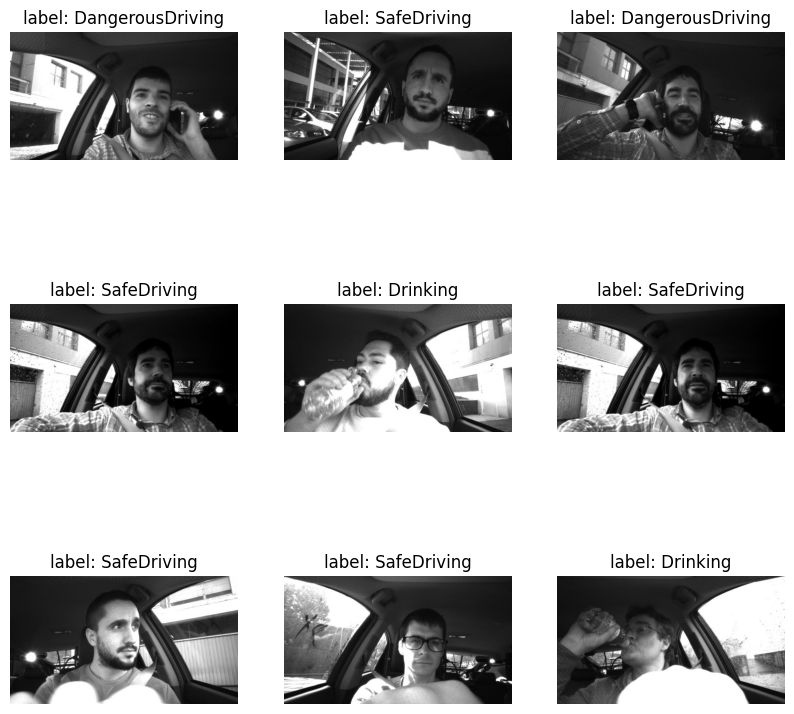

In [ ]:
def load_image_and_label(image_name):

    img_path = os.path.join(train_images_path, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if image_name in annotations:
        class_id = annotations[image_name]
        return img, class_names[class_id]
    else:
        print(f'Warning: No label found for {image_name}')
        return img, "No label"

plt.figure(figsize = (10,10))
image_files = os.listdir(train_images_path)[:9]

for i, image_file in enumerate(image_files):
    img, label = load_image_and_label(image_file)

    ax = plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(f'label: {label}')
    plt.axis('off')

plt.show()

# **Data preprocessing**

In [ ]:
def read_annotations(file_path):
    annotations = []
    with open(file_path,'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 2:
                continue
            image_name = parts[0]
            try:
                bbox = list(map(int,parts[1].split(',')))
                if len(bbox) !=5:
                    continue
                annotations.append([image_name] + bbox)
            except ValueError:
                continue
    return pd.DataFrame(annotations,columns = ['image_name','x_min','y_min','x_max','y_max','class_id'])

In [ ]:
target_size = (224,224)
def preprocess_image(image_path,target_size):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,target_size)
    return image

In [ ]:
def one_hot_encode_labels(labels,num_classes):
    encoder = OneHotEncoder(sparse = False)
    labels = np.array(labels).reshape(-1,1)
    one_hot_labels = encoder.fit_transform(labels)
    return one_hot_labels

In [ ]:
train_folder = '/kaggle/input/driver-inattention-detection-dataset/train'
test_folder = '/kaggle/input/driver-inattention-detection-dataset/test'
valid_folder = '/kaggle/input/driver-inattention-detection-dataset/valid'

train_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/train/_annotations.txt')
test_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/test/_annotations.txt')
valid_annotations = read_annotations('/kaggle/input/driver-inattention-detection-dataset/valid/_annotations.txt')

In [ ]:
def preprocess_dataset(annotations,folder_path,num_classes):
    images = []
    labels = []
#     print(annotations.head())
#     print(annotations.columns)

    for _, row in annotations.iterrows():
        image_path = os.path.join(folder_path,row['image_name'])
        image = preprocess_image(image_path,target_size)
        images.append(image)
        labels.append(row['class_id'])
    images = np.array(images)
    one_hot_labels = one_hot_encode_labels(labels, num_classes)
    return images,one_hot_labels

num_classes = 6

train_images, train_labels = preprocess_dataset(train_annotations,train_folder,num_classes)
test_images, test_labels = preprocess_dataset(test_annotations,test_folder,num_classes)
valid_images, valid_labels = preprocess_dataset(valid_annotations,valid_folder,num_classes)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# **Shape of the dataset after preprocessing steps**

In [ ]:
print(f'Train images shape: {train_images.shape}')
print(f'Train labels shape: {train_labels.shape}')
print(f'Test images shape: {test_images.shape}')
print(f'Test labels shape: {test_labels.shape}')
print(f'Valid images shape: {valid_images.shape}')
print(f'Valid labels shape: {valid_labels.shape}')

Train images shape: (11948, 224, 224, 3)
Train labels shape: (11948, 6)
Test images shape: (985, 224, 224, 3)
Test labels shape: (985, 6)
Valid images shape: (1922, 224, 224, 3)
Valid labels shape: (1922, 6)


In [ ]:
print(type(train_images))
print(type(train_labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# **Assigning the data to Train and Validation**

In [ ]:
(X_train, y_train), (X_val, y_val) = (train_images, train_labels), (valid_images, valid_labels)

# **Neural netowork (CNN model)**

# **Classical CNN model**

In [ ]:
model = Sequential([
    Conv2D(32,(3,3),activation = 'relu',input_shape=(224,224,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(256,(3,3), activation = 'relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation = 'relu'),
    Dropout(0.5),
    Dense(6,activation = 'softmax')
])

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,266,374 (73.50 MB)

 Trainable params: 19,266,374 (73.50 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 30s 66ms/step - accuracy: 0.5272 - loss: 16.9730 - val_accuracy: 0.7903 - val_loss: 0.6471
Epoch 2/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.7427 - loss: 0.7170 - val_accuracy: 0.8288 - val_loss: 0.5384
Epoch 3/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8080 - loss: 0.5428 - val_accuracy: 0.8398 - val_loss: 0.4765
Epoch 4/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8274 - loss: 0.4765 - val_accuracy: 0.8590 - val_loss: 0.4481
Epoch 5/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8541 - loss: 0.4293 - val_accuracy: 0.8829 - val_loss: 0.3789
Epoch 6/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8616 - loss: 0.3863 - val_accuracy: 0.8798 - val_loss: 0.4166
Epoch 7/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8726 - loss: 0.3578 - val_accuracy: 0.8928 - val_loss: 0.3672
Epoch 8/20
374/374 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.8806 - loss: 0.3258 -

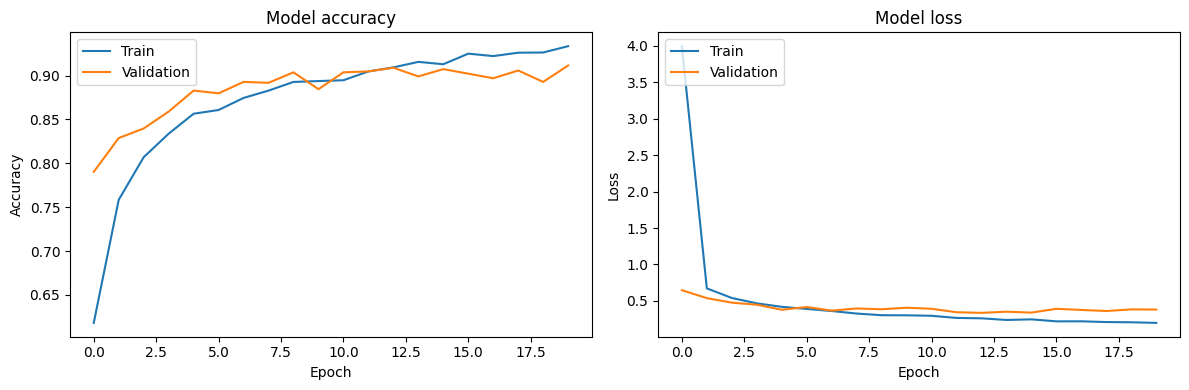

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


# **Plot the first 16 images with actual label and predicted label**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


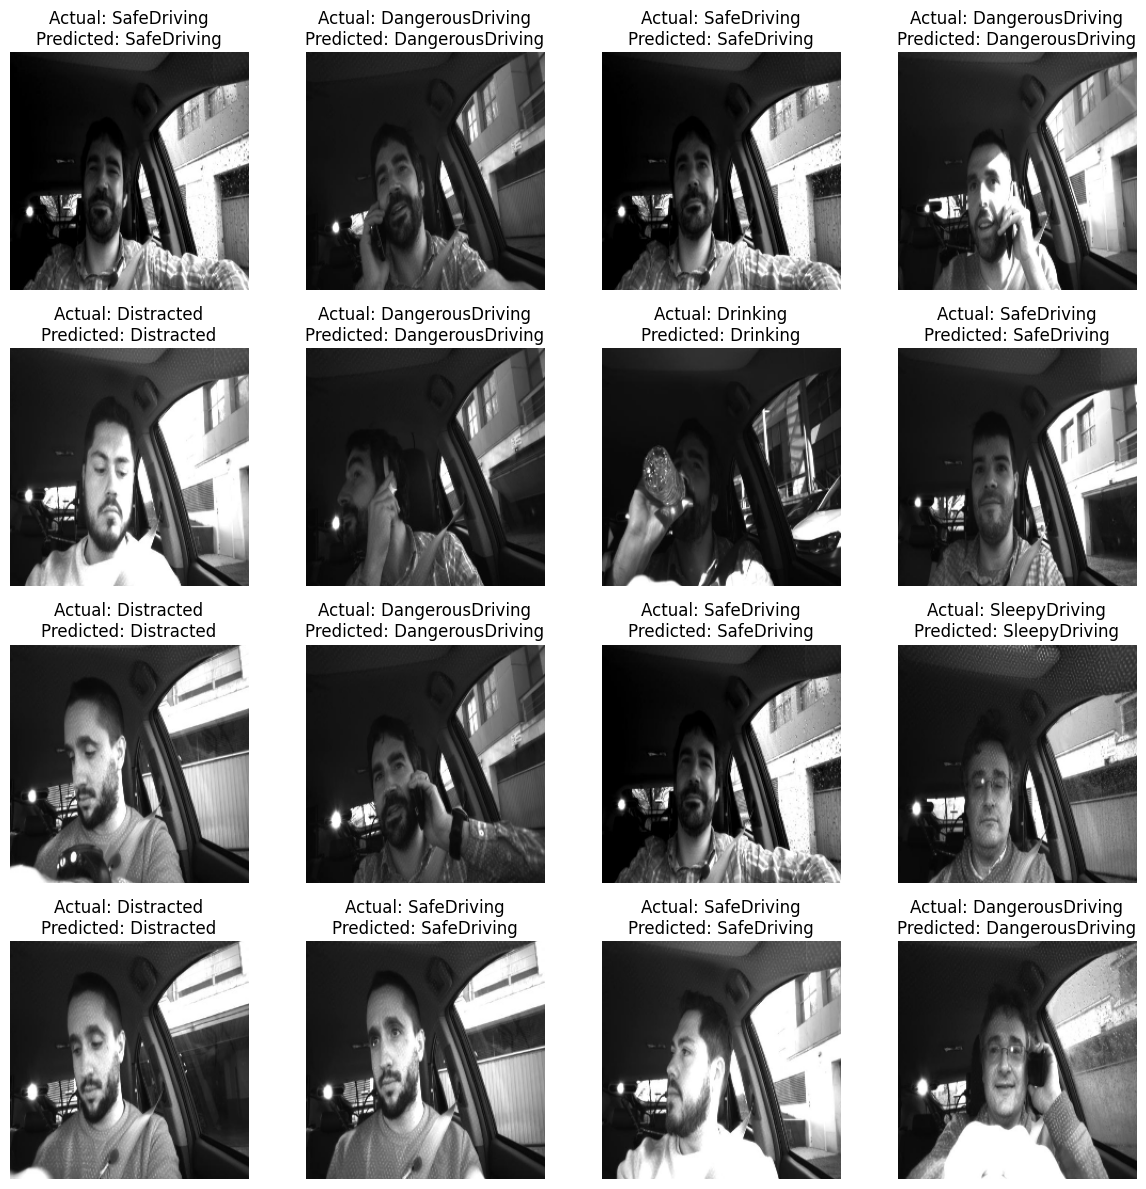

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to plot 16 images in a grid with predicted and actual labels
def plot_images_grid_with_predictions(images, actual_labels, predicted_labels, class_names, grid_size=(4, 4)):
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(12, 12))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            ax.imshow(images[i])
            actual_label = class_names[np.argmax(actual_labels[i])]
            predicted_label = class_names[np.argmax(predicted_labels[i])]
            ax.set_title(f'Actual: {actual_label}\nPredicted: {predicted_label}')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

class_names = ['DangerousDriving', 'Distracted', 'Drinking', 'SafeDriving', 'SleepyDriving', 'Yawn']

# Select 16 random test images
indices = np.random.choice(len(test_images), 16, replace=False)
sample_images = test_images[indices]
sample_actual_labels = test_labels[indices]

# Predict the labels
sample_predicted_labels = model.predict(sample_images)

# Plot the images in a grid with predictions
plot_images_grid_with_predictions(sample_images, sample_actual_labels, sample_predicted_labels, class_names)


# **Accuracy of the test dataset**

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy:.2f}')

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8994 - loss: 0.3856
Test accuracy: 0.90


# **Save the model in h5 version**

In [ ]:
# Save the model
model.save('driving_behavior_model.h5')